In [9]:
import numpy as np
import numpy.random as rnd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

## ClusterSynthesis

In [11]:
pi_true = np.array([0.35, 0.45, 0.2])
mu_true = np.array([[-1, 3], [1, 5], [3,7]])
sigma_true = np.zeros((3, 2, 2))
sigma_true[0] = np.array([[0.9, 0.1], [0.1, 0.9]])/3
sigma_true[1] = np.array([[0.6, 0.4], [0.4, 0.6]])/3
sigma_true[2] = np.array([[0.7, 0.3], [0.3, 0.7]])/3
col = ['red', 'green', 'blue', 'black', 'cyan']                    

In [12]:
N = 100
v = np.zeros((len(pi_true), N, 2))
C = np.zeros(len(pi_true), dtype = 'int64')
obs = np.zeros((N, 2))

In [13]:
for i in range(N):
    z = np.random.random()
    idx = 0
    needle = 0
    
    for j in range(len(pi_true)):
        if z >= needle and z <= needle + pi_true[j]:
            idx = j
            break
        else:
            needle += pi_true[j]
            
    obs[i] = np.random.multivariate_normal(mu_true[idx], sigma_true[idx])
    #draw random samples from multivariate_normal distribution
    C[idx] += 1
    v[idx, C[idx]] = obs[i]

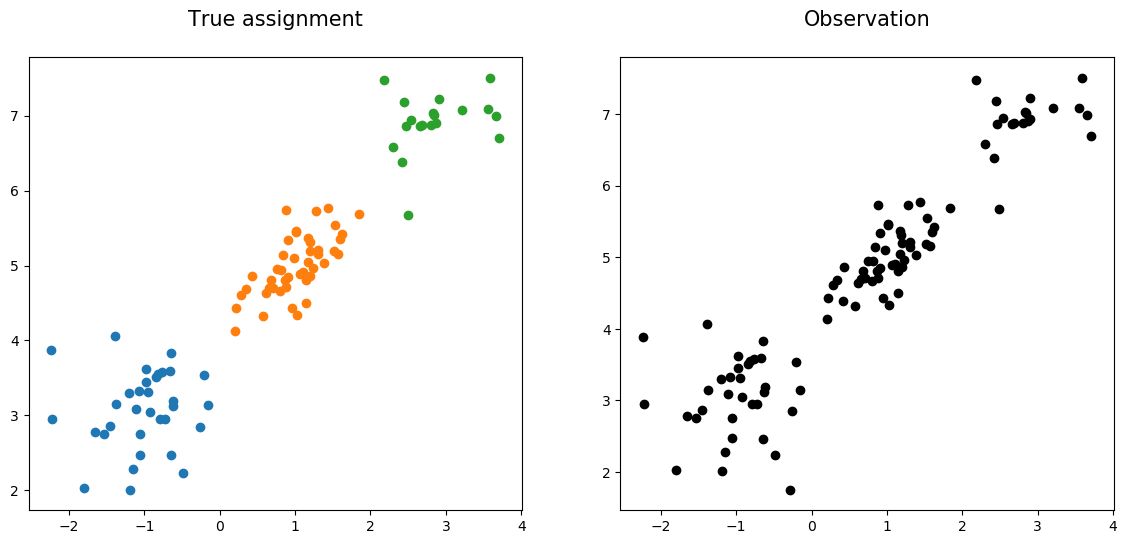

In [14]:
plt.figure(1, figsize=(14, 6), dpi=100)
plt.subplot(121)
plt.title('True assignment\n', fontsize=15)
for i in range(len(pi_true)):
    plt.plot(v[i, 1:C[i], 0], v[i, 1:C[i], 1], 'o')
    
plt.subplot(122)
plt.title('Observation\n', fontsize=15)
plt.plot(obs[:, 0], obs[:, 1], 'ko')

plt.show()

## DPMM

In [15]:
numItr = 100
alpha = 0.01
initK = 10
priorCov = 0.1

minX = np.min(obs[:,0])
maxX = np.max(obs[:,0])
minY = np.min(obs[:,1])
maxY = np.max(obs[:,1])

In [16]:
assignment = rnd.randint(initK, size = N)
clusterIdxs = np.unique(assignment)
#random assignment of clusters for N datas

clusterMean = np.zeros((len(clusterIdxs),2))
clusterCov = np.zeros((len(clusterIdxs), 2, 2))
clusterNum = np.zeros(len(clusterIdxs))


for k in range(len(clusterIdxs)):
    clusterMean[k] = np.mean(obs[np.where(assignment == k)], axis = 0)
    clusterCov[k] = np.cov(obs[np.where(assignment == k)].T)
    clusterNum[k] = len(np.where(assignment == k)[0])


In [34]:
assignment = rnd.randint(initK, size = N)
clusterIdxs = np.unique(assignment)
#random assignment of clusters for N datas

clusterMean = np.zeros((len(clusterIdxs),2))
clusterCov = np.zeros((len(clusterIdxs), 2, 2))
clusterNum = np.zeros(len(clusterIdxs))


for k in range(len(clusterIdxs)):
    clusterMean[k] = np.mean(obs[np.where(assignment == k)], axis = 0)
    clusterCov[k] = np.cov(obs[np.where(assignment == k)].T)
    clusterNum[k] = len(np.where(assignment == k)[0])
    
numItr = 5

for i in range(numItr):
    
    for j in range(N):
        
        idxPrevCluster = assignment[j]
        
        assignment[j] = -1
        
        if clusterNum[idxPrevCluster] == 1:
        #if only one data was assigned to that cluster. 
            numClusterCurrent = np.max(assignment)
            #number of clusters declined (in this code, only 9 clusters remain)
            for k in range(idxPrevCluster, numClusterCurrent):
                
                clusterMean[k] = clusterMean[k+1]
                clusterCov[k] = clusterCov[k+1]
                clusterNum[k] = clusterNum[k+1]
                assignment[np.where(assignment == k+1)] = k    
                
        else:
            
            clusterMean[idxPrevCluster] = np.mean(obs[np.where(assignment == idxPrevCluster)], axis = 0)
            if len(obs[np.where(assignment == idxPrevCluster)]) == 1:
                clusterCov[idxPrevCluster] = (priorCov / clusterNum[idxPrevCluster] + np.cov(obs[np.where(assignment == idxPrevCluster)]))*np.eye(2)
            else:                
                clusterCov[idxPrevCluster] = np.cov(obs[np.where(assignment == idxPrevCluster)].T) + np.eye(2) * priorCov / clusterNum[idxPrevCluster]
            
            clusterNum[idxPrevCluster] = len(np.where(assignment == idxPrevCluster)[0])
            
            if np.isnan(clusterCov[idxPrevCluster][0,0]):
                print(idxPrevCluster)
                print(obs[np.where(assignment == idxPrevCluster)])
    
        idxClusters = np.unique(assignment)
        idxClusters = idxClusters[np.where(idxClusters != -1)]
        numCluster = len(idxClusters)
        
        probAssignment = np.zeros(numCluster)
        probLikelihood = np.zeros(numCluster)
        probPosterior = np.zeros(numCluster+1)
        
        clusterCov = np.nan_to_num(clusterCov)

        for k in range(len(idxClusters)):
            idxCluster = idxClusters[k]           
            probAssignment[k] = clusterNum[idxCluster] / (N + alpha - 1)
            probLikelihood[k] = multivariate_normal.pdf(obs[j,:], mean = clusterMean[idxCluster], 
                                                        cov = clusterCov[idxCluster], allow_singular = True)
            probPosterior[k] = probAssignment[k] * probLikelihood[k]
       
        probPosterior[k + 1] = alpha / (N + alpha - 1)
        
    
        assignment[j] = rnd.choice(numCluster+1, 1, True, probPosterior / np.sum(probPosterior))[0]
   
        
        clusterIdxs = np.unique(assignment)

        
        clusterMean = np.zeros((len(clusterIdxs),2))
        clusterCov = np.zeros((len(clusterIdxs), 2, 2))
        clusterNum = np.zeros(len(clusterIdxs))
        
        for k in range(len(clusterIdxs)):
            clusterMean[k] = np.mean(obs[np.where(assignment == k)], axis = 0)
            if len(obs[np.where(assignment == k)]) == 1:
                clusterCov[k] = (priorCov / clusterNum[k] + np.cov(obs[np.where(assignment == k)]))*np.eye(2)
            else:                
                clusterCov[k] = np.cov(obs[np.where(assignment == k)].T) + np.eye(2) * priorCov / clusterNum[k]
            
            clusterNum[k] = len(np.where(assignment == k)[0])
    
    print('itr : %s'%(i+1))
    print('clusterNumber :',len(np.unique(assignment)))
    print ('assignment status :' , clusterNum)
    print('')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply


itr : 1
clusterNumber : 21
assignment status : [  5.   9.  13.   6.   9.   6.   7.   8.  13.  13.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.]

itr : 2
clusterNumber : 24
assignment status : [  4.   9.  12.   6.   9.   6.   7.   8.  13.  12.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.]

itr : 3
clusterNumber : 26
assignment status : [  3.   9.  12.   6.   9.   6.   7.   7.  13.  12.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]

itr : 4
clusterNumber : 27
assignment status : [  3.   9.  12.   6.   8.   6.   7.   7.  13.  12.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]

itr : 5
clusterNumber : 30
assignment status : [  3.   8.  12.   6.   7.   6.   7.   6.  13.  12.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]

